<a href="https://colab.research.google.com/github/AnoushaPawarCTRL/icebergsFYP/blob/main/Arctic2_0_U_net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Iceberg Segmentation using U-net.

# This notebook will demonstrate the use of U-net to segment icebergs from satellite imagery.
# This model will allow icebergs to be automatically deteceted and segmented so the area and coordinates are constantly being tracked and recorded without the need for manual interruption.
# The data can be used in a variety of ways such as to explore polar ice cap regression.

In [1]:
# Google Drive
from google.colab import drive
import os

mount_point = '/content/drive'

# Ensure the mount point exists and is empty
if os.path.exists(mount_point) and os.listdir(mount_point):
    # If not empty, try to unmount if already mounted, or clear contents (use with caution)
    # For simplicity, we'll try to unmount if it's currently mounted and then mount again.
    # If files persist after unmount, a deeper cleanup or a different mount point might be needed.
    print(f"Mount point '{mount_point}' is not empty. Attempting to force unmount and remount...")
    try:
        drive.flush_and_unmount()
        # Optionally, remove any lingering directories if unmount failed to clear them
        # for item in os.listdir(mount_point):
        #     item_path = os.path.join(mount_point, item)
        #     if os.path.isdir(item_path): os.rmdir(item_path)
        #     else: os.remove(item_path)
        # print("Mount point cleaned.")
    except Exception as e:
        print(f"Could not unmount existing drive: {e}. Please ensure the mount point is clear manually if issues persist.")

drive.mount(mount_point, force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.4 MB/s eta 0:00:00


In [2]:
import rasterio

#images are geotiff,preprocessed in QGIS to retain data

path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif"

with rasterio.open(path) as src:
    print("Is GeoTIFF:", src.crs is not None)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Width x Height:", src.width, "x", src.height)


Is GeoTIFF: True
CRS: EPSG:3031
Transform: | 495.72, 0.00,-2835398.93|
| 0.00,-495.72, 2195508.73|
| 0.00, 0.00, 1.00|
Width x Height: 1414 x 1470


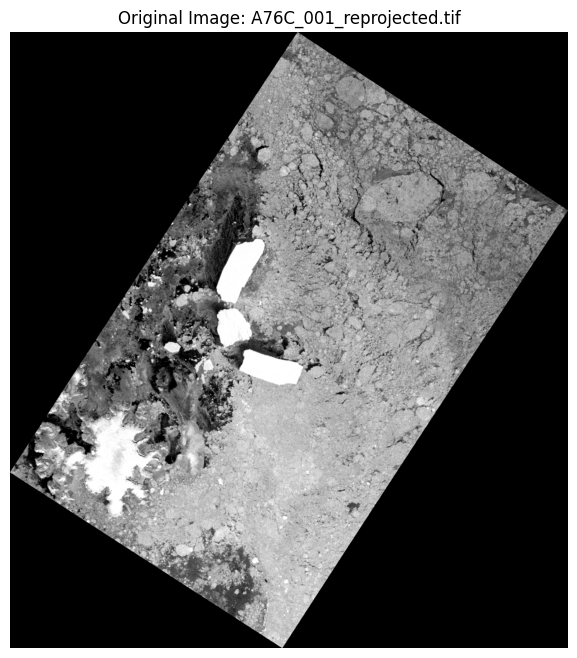

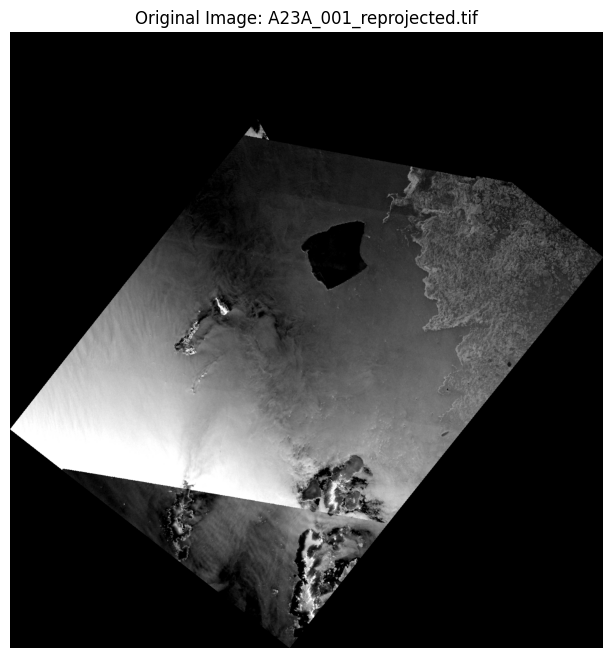

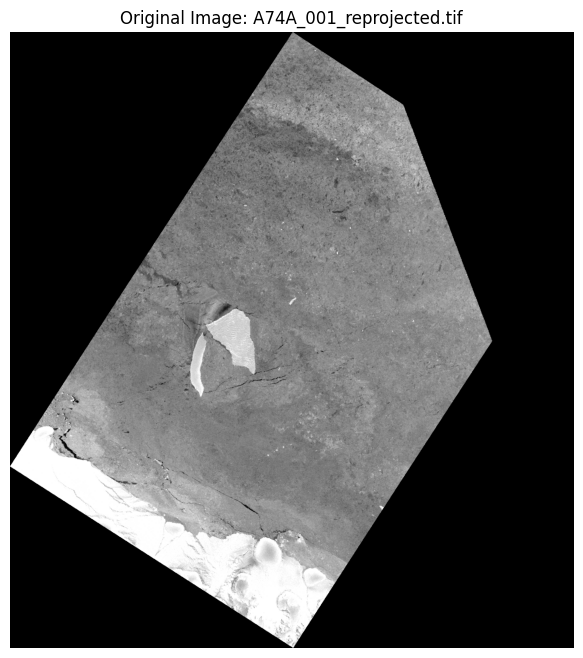

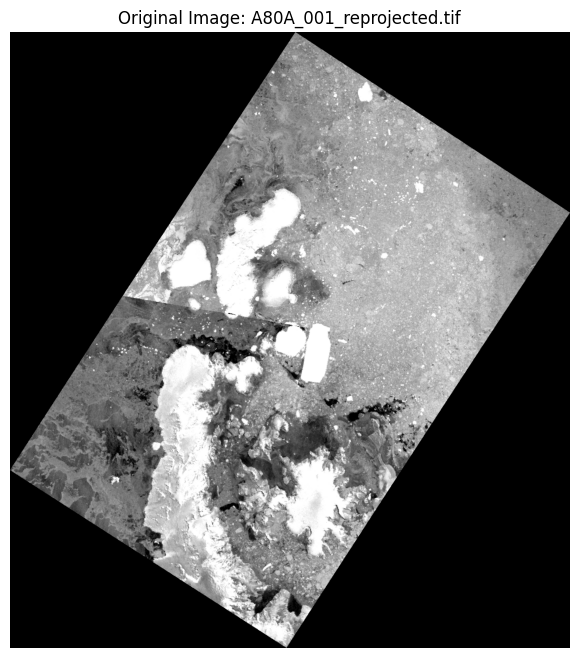

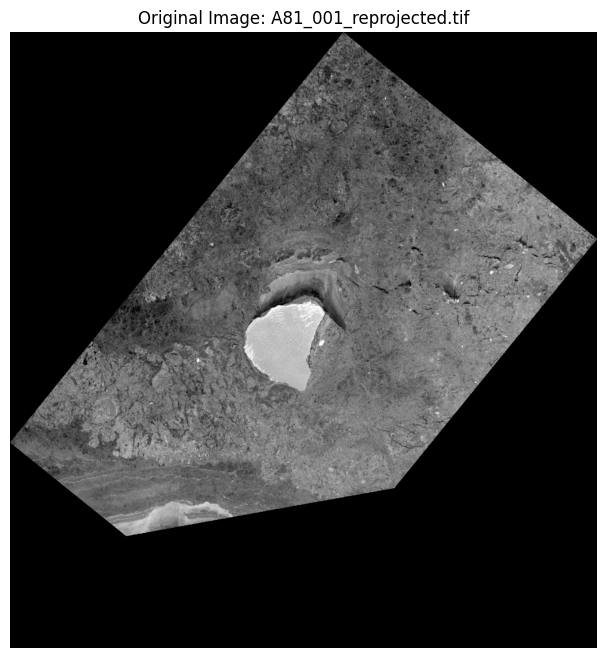

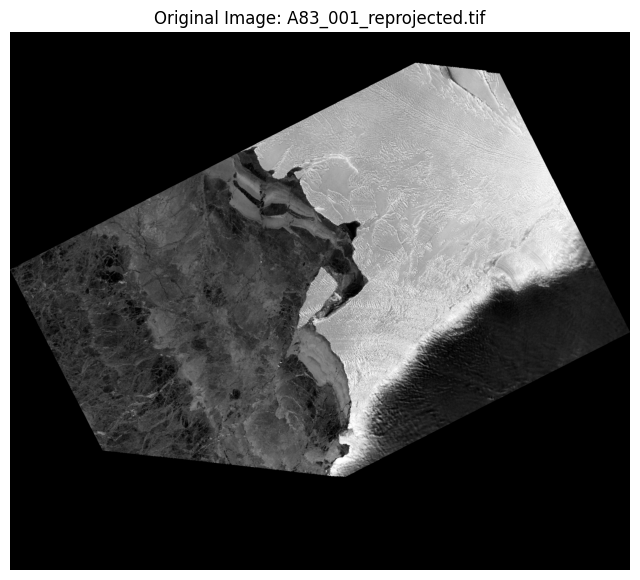

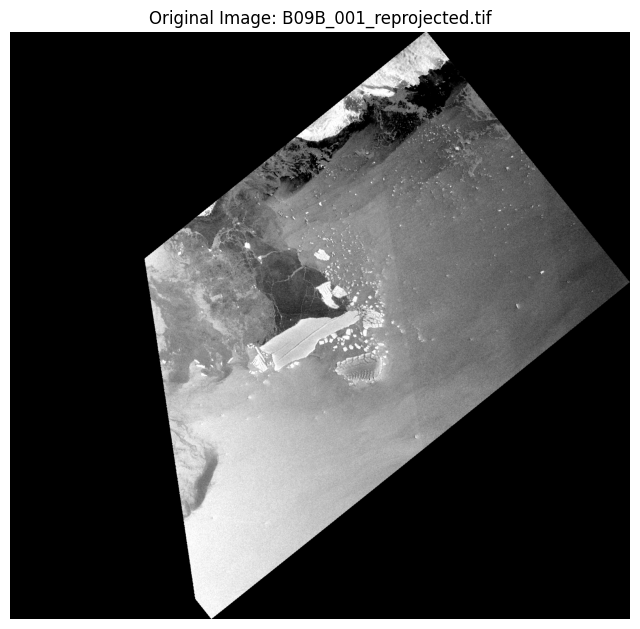

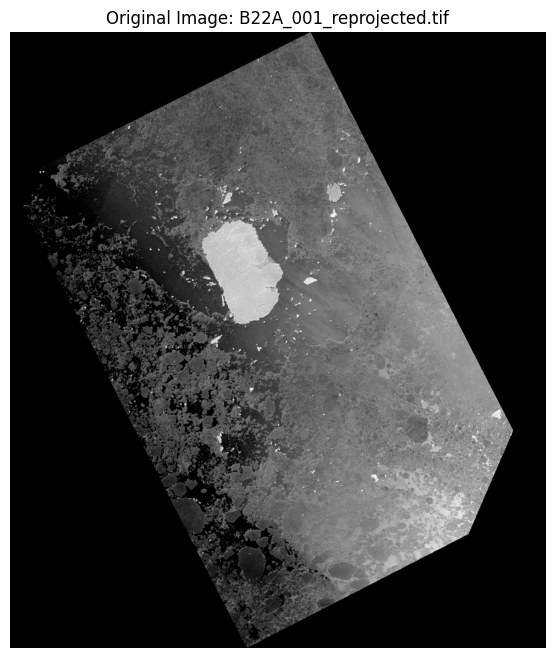

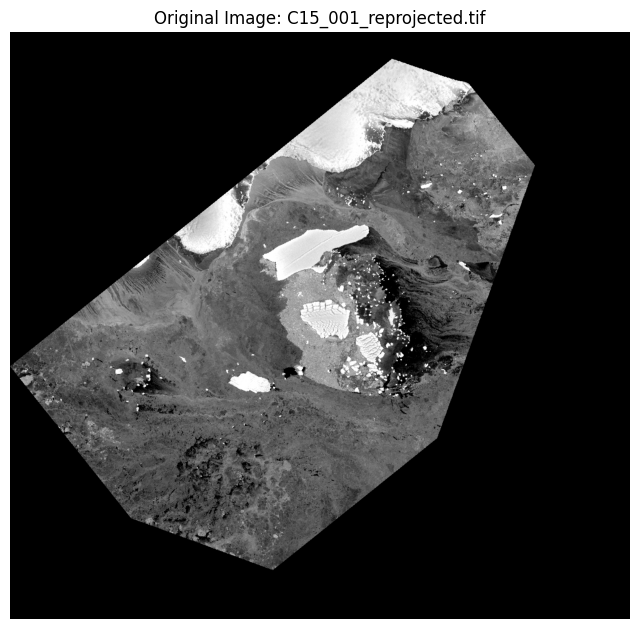

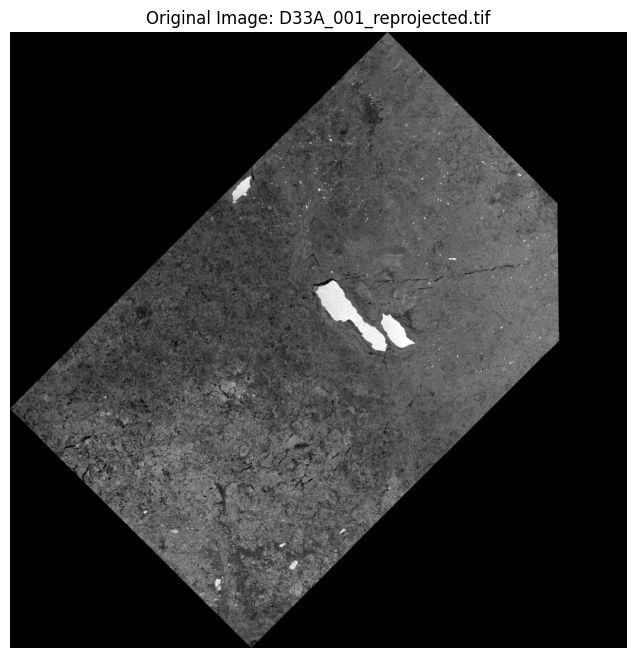

In [3]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

image_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"

# Get a list of all TIFF files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))]

# Display each image
for filename in image_files:
    img_path = os.path.join(image_folder, filename)

    with rasterio.open(img_path) as src:
        img_data = src.read(1)  # Read the first band

    plt.figure(figsize=(8, 8))
    plt.imshow(img_data, cmap='gray')
    plt.title(f"Original Image: {filename}")
    plt.axis('off')
    plt.show()


In [ ]:
#iceberg images to be pre-processed to enhance the iceberg and create a better distinction





In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import os
import numpy as np
import rasterio
import cv2
from sklearn.model_selection import train_test_split

# 2 seperate folders are required for training, original images and their pre-defined binary masks processed in QGIS.
# 100 images were collected from Copernicus browser and downloaded in tiff format to retain important contextual information such as coordinates.
# 10 images were masked for the purpose of proving this solution, due to time constraints 10 was the limitation. It is noted that this quantity does not suffice an accurate model.
image_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"
mask_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked"

# create two empty lists to store the loaded data
def load_data(image_folder, mask_folder):
    images = []
    masks = []

    # as all files pair based on the file naming convention 001-010 the files must be listed in order
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    # pair anc confirm using zip in a loop
    for img_name, mask_name in zip(image_files, mask_files):
        print(f"Image: {img_name}, Mask: {mask_name}")
        # builds a file path to each file
        img_path = os.path.join(image_folder, img_name)
        mask_path = os.path.join(mask_folder, mask_name)

       # pre process the images and masks then add each to lists
        with rasterio.open(img_path) as img_file:
            img = img_file.read(1)  # grayscale band
            img = cv2.resize(img, (256, 256)) # all inputs need to be the same size
            images.append(img)

        with rasterio.open(mask_path) as mask_file:
            mask = mask_file.read(1)
            mask = cv2.resize(mask, (256, 256))  # Resize to match image
            masks.append(mask)

    # convert and normalize for deep learning use
    images = np.expand_dims(np.array(images), axis=-1) / 255.0  # Normalize
    masks = np.expand_dims(np.array(masks), axis=-1) / 255.0  # Normalize
    return np.array(images), np.array(masks)

images, masks = load_data(image_folder, mask_folder) # checks that all files are paired correctly


Image: A23A_001_reprojected.tif, Mask: A23A_001_mask.tif
Image: A74A_001_reprojected.tif, Mask: A74A_001_mask.tif
Image: A76C_001_reprojected.tif, Mask: A76C_001_mask.tif
Image: A80A_001_reprojected.tif, Mask: A80A_001_mask.tif
Image: A81_001_reprojected.tif, Mask: A81_001_mask.tif
Image: A83_001_reprojected.tif, Mask: A83_001_mask.tif
Image: B09B_001_reprojected.tif, Mask: B09B_001_mask.tif
Image: B22A_001_reprojected.tif, Mask: B22A_001_mask.tif
Image: C15_001_reprojected.tif, Mask: C15_001_mask.tif
Image: D33A_001_reprojected.tif, Mask: D33A_001_mask.tif


In [ ]:
# Here a standard u-net architecture has been used
def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder - a series of convolutional layers, starting by capturing larger features and increasing the filters in each block for deeper learning.
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bottleneck - bottom of the U, the bridge between the encoder and decoder. the highest number of filters without pooling to capture larger patterns.
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder - restore image to its original size
    up5 = UpSampling2D((2, 2))(conv4) # doubles spatial size
    merge5 = Concatenate()([conv3, up5]) # merges features - "skip connections" to keep fine spatial details that could be lost during pooling
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6) # back to original size
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7) # segmented mask prediction, sigmoid function means values closer to 1 indicate iceberg and 0 is non iceberg

    model = Model(inputs, outputs) # creates a single keras model
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adjusting the weights, measuring loss and acuracy.


In [ ]:
# Bootstrapping
# now the model must be trained and evaluated in a variety of ways
# bootstrapping is a great way to test the models bias on a smaller dataset
# statistical evaluation, is there a difference in f1 scores in each sample set?

from sklearn.utils import resample
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_score(y_true, y_pred):
    # convert probability values to binary 0/1 mask using a threshold
    y_pred = (y_pred > 0.4).astype(int)
    y_true = y_true.astype(int)  #ensuring the real mask is also set to int

    # flatten for F1 calculation
    y_true = y_true.flatten()   # scikit-learn expects 1d array
    y_pred = y_pred.flatten()

    return f1_score(y_true, y_pred) # f1 score


n_iterations = 10   # number of bootstrap samples
f1_scores = [] #store all f1 scores

for i in range(n_iterations):
    print(f"\nBootstrap iteration {i+1}/{n_iterations}") # track bootstrapping process

    # create the bootstrap sample
    X_train, y_train = resample(
        images, masks,
        replace=True,
        n_samples=len(images),
        random_state=i #random state ensures a different random sample is generated in every iteration
    )

    # creating train and test sets
    X_train_set = set([id(x) for x in X_train])
    X_test, y_test = [], []
    for img, mask in zip(images, masks):
        if id(img) not in X_train_set:
            X_test.append(img)
            y_test.append(mask)

    # checking the test set isnt empty
    if len(X_test) == 0:
        print("⚠️ All samples used in training; skipping iteration.")
        continue

    # train
    model.fit(
        np.array(X_train), np.array(y_train),
        epochs=10,
        batch_size=4,
        verbose=0
    )

    # test
    predictions = model.predict(np.array(X_test))
    score = calculate_f1_score(np.array(y_test), predictions)
    f1_scores.append(score)

    print(f"F1 Score (iteration {i+1}): {score:.3f}")


print("\nBootstrapping Evaluation Results:")
print(f"Average F1 Score: {np.mean(f1_scores):.3f}")
print(f"Standard Deviation: {np.std(f1_scores):.3f}")



In [ ]:
# K-Fold cross validation
# suitable for small datasets as it uses all the data, will help with generalising to unseen data rather than a sinle train-test set

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np


def calculate_f1_score(y_true, y_pred):
    y_pred = (y_pred > 0.4).astype(int)
    y_true = y_true.astype(int)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return f1_score(y_true, y_pred)


k = 5  # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42) #create k-fold instance

f1_scores = []

fold = 1
for train_idx, val_idx in kf.split(images): #split sets
    print(f"\n🔹 Fold {fold}/{k}") #print current fold number

    # selecting data for current fold
    X_train, X_val = np.array(images)[train_idx], np.array(images)[val_idx]
    y_train, y_val = np.array(masks)[train_idx], np.array(masks)[val_idx]

    # fresh model for each fold
    model = unet()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # train
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=4,
        verbose=0
    )

    # validation
    predictions = model.predict(X_val)
    score = calculate_f1_score(y_val, predictions)
    f1_scores.append(score)

    print(f"Fold {fold} F1 Score: {score:.3f}")
    fold += 1


print("\nK-Fold Cross Validation Results:")
print(f"Average F1 Score: {np.mean(f1_scores):.3f}")
print(f"Standard Deviation: {np.std(f1_scores):.3f}")


In [ ]:
# black box testing

import numpy as np
import matplotlib.pyplot as plt
import cv2


test_images = "" #add test data

def black_box_tests(model, test_images):
    print("Running black box tests...\n")

    for i, img in enumerate(test_images):
        print(f"Test Case {i+1}")

        # 1. Check prediction shape dimensions
        prediction = model.predict(np.expand_dims(img, axis=0))
        assert prediction.shape[1:3] == img.shape[:2], "Output does not match!" #assert checks if the condition is true otherwise continue
        print("Output shape matches")

        # 2. Check output value range
        assert prediction.min() >= 0 and prediction.max() <= 1, "Output values not normalized (0–1)"
        print("Output normalization test passed")

        # 3. Test with noise/brightness variation
        noisy_img = img + np.random.normal(0, 0.05, img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        noisy_pred = model.predict(np.expand_dims(noisy_img, axis=0))
        diff = np.mean(np.abs(prediction - noisy_pred)) # compares the clean img prediction with the noisy img prediction
        print(f"Output difference with noise: {diff:.4f}")
        if diff < 0.1:
            print("Model robust to noise\n")
        else:
            print("Model sensitive to input noise\n")

        # 4. Visual check
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img.squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(prediction.squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Noisy Prediction")
        plt.imshow(noisy_pred.squeeze(), cmap='gray')
        plt.show()

# Run test on a few unseen images
black_box_tests(model, test_images[:4])

#test images should include similar images to check consistency with predictions

In [ ]:
#inference time test

import time
import numpy as np

#load and pre-process test img
new_image_path = ""
with rasterio.open(new_image_path) as img_file:
  sample_image = img_file.read(1) # read band
  sample_image = cv2.resize(sample_image, (256, 256))
  sample_image = np.expand_dims(sample_image, axis=-1) / 255.0
  sample_image = np.expand_dims(sample_image, axis=0)

_ = model.predict(img) #the output is irrelevant but the model must be warmed up

def measure_inference_time(model, sample_image, runs=10):
    times = []
    for _ in range(runs):  #ignore the index as we repeat this
        start = time.time()
        _ = model.predict(sample, verbose=0)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    std_dev = np.std(times)
    return avg_time, std_dev, times[0]

avg, std, first = measure_inference_time(model, img)

print(f"First inference time: {first*1000:.2f} ms")
print(f"Average inference time over 50 runs: {avg*1000:.2f} ms")
print(f"Standard deviation: {std*1000:.2f} ms")


In [ ]:
# memory usage test

import psutil
import numpy as np
import tensorflow as tf
import time


sample_input = np.random.rand(256, 256, 1).astype('float32')

# Measure memory before inference
process = psutil.Process()
mem_before = process.memory_info().rss / (1024 ** 2)  # in MB


_ = model.predict(dummy_input)

# Measure memory after inference
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory before:  {mem_before:.2f} MB")
print(f"Memory after:   {mem_after:.2f} MB")
print(f"Memory used:    {mem_after - mem_before:.2f} MB")


In [ ]:
# white box testing/ explainability




In [ ]:
# Save the model
model.save("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
import rasterio
import cv2
import numpy as np

# Path to the new image
new_image_path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif"  # Replace with your image path

# Load the image using rasterio
with rasterio.open(new_image_path) as img_file:
    image = img_file.read(1)

# Resize the image to match the model's input shape
image = cv2.resize(image, (256, 256))

# Normalize the image
image = np.expand_dims(image, axis=-1) / 255.0
image = np.expand_dims(image, axis=0)  # Add batch dimension

In [ ]:
# Predict the mask
predicted_mask = model.predict(image)

# Threshold the prediction to get a binary mask
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


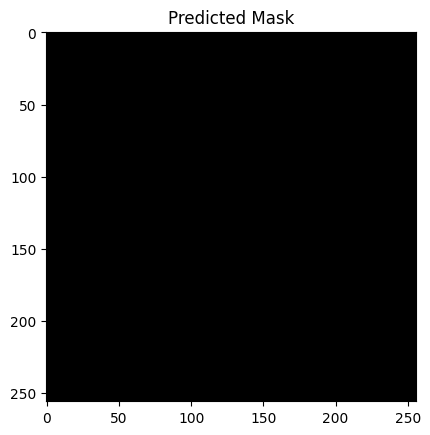

In [ ]:
import matplotlib.pyplot as plt


predicted_mask = predicted_mask.squeeze()

#display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()